In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10

In [3]:
# Carica il dataset
data_path = '../data/PRSA_data_2010.1.1-2014.12.31_Beijing.csv'

df = pd.read_csv(data_path)
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

In [4]:
# Funzione per classificare PM2.5 secondo standard EPA
def classify_pm25_epa(pm25_value):
    """
    Classifica un valore PM2.5 secondo gli standard EPA.
    
    Parameters:
    -----------
    pm25_value : float
        Valore PM2.5 in μg/m³
    
    Returns:
    --------
    str : Categoria EPA
    """
    if pd.isna(pm25_value):
        return 'Missing'
    elif pm25_value <= 12.0:
        return 'Good'
    elif pm25_value <= 35.4:
        return 'Moderate'
    elif pm25_value <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    elif pm25_value <= 150.4:
        return 'Unhealthy'
    elif pm25_value <= 250.4:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

# Applica classificazione al dataset
df['epa_category'] = df['pm2.5'].apply(classify_pm25_epa)

print(f"\nDistribuzione categorie EPA:")
print(df['epa_category'].value_counts().sort_index())
print(f"\nPercentuali:")
print(df['epa_category'].value_counts(normalize=True).sort_index() * 100)


Distribuzione categorie EPA:
epa_category
Good                               3387
Hazardous                          3053
Missing                            2067
Moderate                           8733
Unhealthy                         15643
Unhealthy for Sensitive Groups     5003
Very Unhealthy                     5938
Name: count, dtype: int64

Percentuali:
epa_category
Good                               7.728642
Hazardous                          6.966502
Missing                            4.716594
Moderate                          19.927437
Unhealthy                         35.695053
Unhealthy for Sensitive Groups    11.416119
Very Unhealthy                    13.549653
Name: proportion, dtype: float64


In [5]:
# Import librerie per deep learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [6]:
# Installa PyTorch se necessario
import subprocess
import sys

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "-q"])
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset

In [7]:
print(f"\nDistribuzione categorie EPA:")
print(df['epa_category'].value_counts())




Distribuzione categorie EPA:
epa_category
Unhealthy                         15643
Moderate                           8733
Very Unhealthy                     5938
Unhealthy for Sensitive Groups     5003
Good                               3387
Hazardous                          3053
Missing                            2067
Name: count, dtype: int64


In [8]:
def create_cumulative_wind_direction(df):
    """
    Crea una feature che accumula la velocità del vento in una direzione specifica.
    Poiché Iws è già cumulata, calcoliamo l'incremento orario (differenza) 
    e lo sommiamo finché la direzione rimane la stessa.
    Quando la direzione cambia, il contatore si resetta.
    
    Args:
        df: DataFrame con colonne 'cbwd' e 'Iws'
        
    Returns:
        pd.Series: Velocità cumulata del vento per direzione (CWD)
    """
    # Inizializza array per CWD
    cwd = np.zeros(len(df))
    
    # Prima riga: Iws iniziale
    cwd[0] = df['Iws'].iloc[0] if pd.notna(df['Iws'].iloc[0]) else 0
    
    # Itera attraverso le righe
    for i in range(1, len(df)):
        current_dir = df['cbwd'].iloc[i]
        prev_dir = df['cbwd'].iloc[i-1]
        current_iws = df['Iws'].iloc[i]
        prev_iws = df['Iws'].iloc[i-1]
        
        # Calcola incremento orario (differenza di Iws)
        if pd.notna(current_iws) and pd.notna(prev_iws):
            iws_increment = current_iws - prev_iws
        else:
            iws_increment = 0
        
        # Se direzione cambia o è NaN, resetta a incremento corrente
        if pd.isna(current_dir) or pd.isna(prev_dir) or current_dir != prev_dir:
            cwd[i] = iws_increment if iws_increment >= 0 else 0
        else:
            # Stessa direzione: accumula l'incremento
            cwd[i] = cwd[i-1] + (iws_increment if iws_increment >= 0 else 0)
    
    return pd.Series(cwd, index=df.index, name='CWD')

In [9]:
# Feature Engineering: estrazione informazioni temporali
df_clean = df[df['epa_category'] != 'Missing'].copy()
df_clean.drop(columns=['No','pm2.5'], inplace=True)

# Estrai feature temporali dall'indice
df_clean['year'] = df_clean.index.year
df_clean['month'] = df_clean.index.month
df_clean['day'] = df_clean.index.day
df_clean['hour'] = df_clean.index.hour
df_clean['dayofweek'] = df_clean.index.dayofweek  # 0=Lunedì, 6=Domenica
df_clean['dayofyear'] = df_clean.index.dayofyear

# Crea feature CWD
df_clean['CWD'] = create_cumulative_wind_direction(df_clean)
# One-hot encoding per direzione vento (cbwd)
cbwd_dummies = pd.get_dummies(df_clean['cbwd'], prefix='wind')
df_clean.drop('cbwd', axis=1, inplace=True)
df_clean = pd.concat([df_clean, cbwd_dummies], axis=1)


df_clean['is_winter'] = ((df_clean['month'] == 12) | (df_clean['month'] <= 2)).astype(int)
df_clean['is_spring'] = ((df_clean['month'] >= 3) & (df_clean['month'] <= 5)).astype(int)
df_clean['is_summer'] = ((df_clean['month'] >= 6) & (df_clean['month'] <= 8)).astype(int)
df_clean['is_autumn'] = ((df_clean['month'] >= 9) & (df_clean['month'] <= 11)).astype(int)

df_clean['is_night'] = ((df_clean['hour'] >= 0) & (df_clean['hour'] < 6)).astype(int)
df_clean['is_morning'] = ((df_clean['hour'] >= 6) & (df_clean['hour'] < 12)).astype(int)
df_clean['is_afternoon'] = ((df_clean['hour'] >= 12) & (df_clean['hour'] < 18)).astype(int)
df_clean['is_evening'] = ((df_clean['hour'] >= 18) & (df_clean['hour'] < 24)).astype(int)

df_clean['is_weekend'] = (df_clean['dayofweek'] >= 5).astype(int)

# includiamo anche i valori delle 12 ore precedenti delle feature originali numeriche
for feature in ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir','CWD']:
    for lag in range(1, 13):
        df_clean[f'{feature}_lag_{lag}'] = df_clean[feature].shift(lag) 
# Rimuovi righe con missing values introdotti dal lagging
df_clean = df_clean.dropna()
print(f"\nShape finale: {df_clean.shape}")
display(df_clean.head())


Shape finale: (41745, 111)


,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,...,CWD_lag_3,CWD_lag_4,CWD_lag_5,CWD_lag_6,CWD_lag_7,CWD_lag_8,CWD_lag_9,CWD_lag_10,CWD_lag_11,CWD_lag_12
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-02 12:00:00,2010,1,2,12,-8,-5.0,1026.0,23.69,0,0,...,14.30,12.51,10.72,8.93,7.14,6.25,5.36,3.57,2.68,1.79
2010-01-02 13:00:00,2010,1,2,13,-8,-5.0,1025.0,27.71,0,0,...,17.43,14.30,12.51,10.72,8.93,7.14,6.25,5.36,3.57,2.68
2010-01-02 14:00:00,2010,1,2,14,-9,-5.0,1025.0,31.73,0,0,...,20.56,17.43,14.30,12.51,10.72,8.93,7.14,6.25,5.36,3.57
2010-01-02 15:00:00,2010,1,2,15,-9,-5.0,1025.0,35.75,0,0,...,23.69,20.56,17.43,14.30,12.51,10.72,8.93,7.14,6.25,5.36
2010-01-02 16:00:00,2010,1,2,16,-9,-5.0,1026.0,37.54,0,0,...,27.71,23.69,20.56,17.43,14.30,12.51,10.72,8.93,7.14,6.25


In [10]:

feature_cols = [col for col in df_clean.columns if col != 'epa_category']
target = df_clean['epa_category']
X = df_clean[feature_cols].values
y = df_clean['epa_category'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Encode categorie EPA in numeri
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nEncoding categorie EPA:")
for i, category in enumerate(label_encoder.classes_):
    print(f"   {i}: {category} ({(y == category).sum():,} samples)")

X shape: (41745, 110)
y shape: (41745,)

Encoding categorie EPA:
   0: Good (3,387 samples)
   1: Hazardous (3,053 samples)
   2: Moderate (8,733 samples)
   3: Unhealthy (15,634 samples)
   4: Unhealthy for Sensitive Groups (5,003 samples)
   5: Very Unhealthy (5,935 samples)


In [11]:
# Split train/test e normalizzazione
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_encoded  # Mantieni proporzioni categorie
)
print(f"   Train: X={X_train.shape}, y={y_train.shape}")
print(f"   Test:  X={X_test.shape}, y={y_test.shape}")

# Verifica distribuzione stratificata
print(f"\nDistribuzione categorie nel train set:")
for i, category in enumerate(label_encoder.classes_):
    count = (y_train == i).sum()
    pct = count / len(y_train) * 100
    print(f"   {category}: {count:,} ({pct:.2f}%)")

print(f"\nDistribuzione categorie nel test set:")
for i, category in enumerate(label_encoder.classes_):
    count = (y_test == i).sum()
    pct = count / len(y_test) * 100
    print(f"   {category}: {count:,} ({pct:.2f}%)")

# Normalizzazione features
print(f"\nNormalizzazione features (StandardScaler)")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   X_train_scaled shape: {X_train_scaled.shape}")
print(f"   X_test_scaled shape:  {X_test_scaled.shape}")

   Train: X=(29221, 110), y=(29221,)
   Test:  X=(12524, 110), y=(12524,)

Distribuzione categorie nel train set:
   Good: 2,371 (8.11%)
   Hazardous: 2,137 (7.31%)
   Moderate: 6,113 (20.92%)
   Unhealthy: 10,944 (37.45%)
   Unhealthy for Sensitive Groups: 3,502 (11.98%)
   Very Unhealthy: 4,154 (14.22%)

Distribuzione categorie nel test set:
   Good: 1,016 (8.11%)
   Hazardous: 916 (7.31%)
   Moderate: 2,620 (20.92%)
   Unhealthy: 4,690 (37.45%)
   Unhealthy for Sensitive Groups: 1,501 (11.98%)
   Very Unhealthy: 1,781 (14.22%)

Normalizzazione features (StandardScaler)
   X_train_scaled shape: (29221, 110)
   X_test_scaled shape:  (12524, 110)
   X_train_scaled shape: (29221, 110)
   X_test_scaled shape:  (12524, 110)


In [12]:
# Installa Optuna se necessario (per hyperparameter optimization)
try:
    import optuna
    print(f"Optuna version: {optuna.__version__}")
except ImportError:
    print("Installazione Optuna...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna", "-q"])
    import optuna
    print(f"Optuna installato! Version: {optuna.__version__}")

# Verifica PyTorch e configura device
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Optuna version: 4.6.0
PyTorch version: 2.9.1
CUDA available: False
Device: cpu


In [13]:
# Definizione del modello PyTorch DNN
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rates, n_classes=6, activation='relu'):
        """
        DNN per classificazione EPA.
        
        Args:
            input_size: Numero di feature in input
            hidden_sizes: Lista con numero di neuroni per layer
            dropout_rates: Lista con dropout rate per ogni layer
            n_classes: Numero di classi output (default 6 per EPA)
            activation: Funzione di attivazione ('relu', 'elu', 'selu','leaky_relu')
        """
        super(DNNClassifier, self).__init__()
        
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'elu':
            self.activation = nn.ELU()
        elif activation == 'selu':
            self.activation = nn.SELU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        else:
            self.activation = nn.ReLU()
        
        # Hidden layers
        prev_size = input_size
        for hidden_size, dropout_rate in zip(hidden_sizes, dropout_rates):
            self.layers.append(nn.Linear(prev_size, hidden_size))
            self.batch_norms.append(nn.BatchNorm1d(hidden_size))
            self.dropouts.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Output layer
        self.output_layer = nn.Linear(prev_size, n_classes)
    
    def forward(self, x):
        for layer, bn, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = layer(x)
            x = bn(x)
            x = self.activation(x)
            x = dropout(x)
        
        x = self.output_layer(x)
        return x

In [14]:
# Configurazione path per salvataggio
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

best_model_path = models_dir / 'best_dnn_epa_classifier_deep.pth'
optuna_db_path = models_dir / 'optuna_study_deep.db'
best_params_path = models_dir / 'best_hyperparameters_deep.pkl'

print(f"Directory modelli: {models_dir}")
print(f"Path modello migliore: {best_model_path}")
print(f"Path database Optuna: {optuna_db_path}")
print(f"Path best hyperparameters: {best_params_path}")

Directory modelli: ../models
Path modello migliore: ../models/best_dnn_epa_classifier_deep.pth
Path database Optuna: ../models/optuna_study_deep.db
Path best hyperparameters: ../models/best_hyperparameters_deep.pkl


In [15]:
# Funzioni di supporto per training PyTorch
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Training per una singola epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    return total_loss / len(train_loader), correct / total


def evaluate(model, val_loader, criterion, device):
    """Valutazione del modello"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    return total_loss / len(val_loader), correct / total


# Objective function per Optuna
def objective(trial):
    """
    Funzione obiettivo per Optuna hyperparameter optimization.
    """
    # Hyperparameters da ottimizzare
    n_layers = trial.suggest_int('n_layers', 2, 5)
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'selu','leaky_relu'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    
    hidden_sizes = []
    dropout_rates = []
    for i in range(n_layers):
        units = trial.suggest_int(f'units_{i}', 32, 1024, step=32)
        dropout = trial.suggest_float(f'dropout_{i}', 0.1, 0.5, step=0.1)
        hidden_sizes.append(units)
        dropout_rates.append(dropout)
    
    # Split validation dal training set
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_scaled, y_train, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train
    )
    
    # Crea DataLoaders
    train_dataset = TensorDataset(
        torch.FloatTensor(X_tr), 
        torch.LongTensor(y_tr)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val), 
        torch.LongTensor(y_val)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Crea modello
    model = DNNClassifier(
        input_size=X_train_scaled.shape[1],
        hidden_sizes=hidden_sizes,
        dropout_rates=dropout_rates,
        n_classes=len(label_encoder.classes_),
        activation=activation
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training con early stopping
    best_val_acc = 0
    patience = 30
    patience_counter = 0
    
    for epoch in range(250):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
        
        # Report a Optuna
        trial.report(val_acc, epoch)
        
        # Pruning (opzionale)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return best_val_acc


In [16]:
# Hyperparameter Optimization con Optuna
# Se il modello esiste già, viene caricato; altrimenti si esegue l'ottimizzazione
import pickle

if best_model_path.exists() and best_params_path.exists():
    print(f"Modello esistente trovato: {best_model_path}")
    
    # Carica hyperparameters
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)
    
    # Ricostruisci modello
    n_layers = best_params['n_layers']
    hidden_sizes = [best_params[f'units_{i}'] for i in range(n_layers)]
    dropout_rates = [best_params[f'dropout_{i}'] for i in range(n_layers)]
    
    best_model = DNNClassifier(
        input_size=X_train_scaled.shape[1],
        hidden_sizes=hidden_sizes,
        dropout_rates=dropout_rates,
        n_classes=len(label_encoder.classes_),
        activation=best_params['activation']
    ).to(device)
    
    # Carica pesi
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    best_model.eval()
    
    print(f"\nArchitettura del modello:")
    print(f"  - Layers: {n_layers}")
    print(f"  - Hidden sizes: {hidden_sizes}")
    print(f"  - Dropout rates: {dropout_rates}")
    print(f"  - Activation: {best_params['activation']}")
    print(f"  - Learning rate: {best_params['learning_rate']:.2e}")
    
else:
    print("Modello non trovato. Avvio Hyperparameter Optimization.")
    
    # Crea studio Optuna
    study = optuna.create_study(
        direction='maximize',
        study_name='epa_classification_leaky_deep',
        storage=f'sqlite:///{optuna_db_path}',
        load_if_exists=True
    )
    
    print("Configurazione Optuna:")
    print(f"  - Direction: maximize")
    print(f"  - N trials: 50")
    print(f"  - Objective: validation accuracy")
    print(f"  - Database: {optuna_db_path}")
    
    # Esegui ottimizzazione
    print("\nAvvio ricerca hyperparameters...")
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    # Migliori hyperparameters
    best_params = study.best_params
    best_trial = study.best_trial
    
    print("\n" + "="*60)
    print("MIGLIORI HYPERPARAMETERS TROVATI:")
    print("="*60)
    print(f"  - Best validation accuracy: {best_trial.value:.4f}")
    print(f"  - Numero layer: {best_params['n_layers']}")
    print(f"  - Activation: {best_params['activation']}")
    print(f"  - Learning rate: {best_params['learning_rate']:.2e}")
    print(f"  - Batch size: {best_params['batch_size']}")
    for i in range(best_params['n_layers']):
        print(f"  - Layer {i+1}: {best_params[f'units_{i}']} units, dropout={best_params[f'dropout_{i}']:.2f}")
    print("="*60)
    
    # Salva hyperparameters
    with open(best_params_path, 'wb') as f:
        pickle.dump(best_params, f)
    print(f"\n✓ Hyperparameters salvati: {best_params_path}")
    
    # Training finale con migliori hyperparameters su intero training set
    print("\nAddestramento modello finale con migliori hyperparameters...")
    
    n_layers = best_params['n_layers']
    hidden_sizes = [best_params[f'units_{i}'] for i in range(n_layers)]
    dropout_rates = [best_params[f'dropout_{i}'] for i in range(n_layers)]
    
    best_model = DNNClassifier(
        input_size=X_train_scaled.shape[1],
        hidden_sizes=hidden_sizes,
        dropout_rates=dropout_rates,
        n_classes=len(label_encoder.classes_),
        activation=best_params['activation']
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Split validation per training finale
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_scaled, y_train, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_train
    )
    
    train_dataset = TensorDataset(torch.FloatTensor(X_tr), torch.LongTensor(y_tr))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
    
    # Training loop con early stopping
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(250):
        train_loss, train_acc = train_epoch(best_model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(best_model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping e checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(best_model.state_dict(), best_model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                  f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    # Carica best weights
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    print(f"\nModello salvato: {best_model_path}")
    
    # Salva training history
    history_path = models_dir / 'dnn_training_history.pkl'
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)
    print(f"Training history salvata: {history_path}")

Modello esistente trovato: ../models/best_dnn_epa_classifier_deep.pth

Architettura del modello:
  - Layers: 5
  - Hidden sizes: [992, 800, 832, 736, 320]
  - Dropout rates: [0.30000000000000004, 0.2, 0.2, 0.5, 0.5]
  - Activation: relu
  - Learning rate: 2.49e-02


In [17]:
# Valutazione del modello sul test set
print("Valutazione sul Test Set:")
print("="*60)

best_model.eval()

# Crea test DataLoader
test_dataset = TensorDataset(torch.FloatTensor(X_test_scaled), torch.LongTensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = evaluate(best_model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predizioni complete
all_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = best_model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())

y_pred_classes = np.array(all_preds)

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT:")
print("="*60)
print(classification_report(
    y_test, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
))

Valutazione sul Test Set:
Test Loss: 0.7550
Test Accuracy: 0.7018 (70.18%)
Test Loss: 0.7550
Test Accuracy: 0.7018 (70.18%)

CLASSIFICATION REPORT:
                                precision    recall  f1-score   support

                          Good     0.7134    0.5463    0.6187      1016
                     Hazardous     0.7651    0.7609    0.7630       916
                      Moderate     0.6636    0.7882    0.7205      2620
                     Unhealthy     0.7553    0.8390    0.7949      4690
Unhealthy for Sensitive Groups     0.5285    0.3458    0.4180      1501
                Very Unhealthy     0.6649    0.5716    0.6147      1781

                      accuracy                         0.7018     12524
                     macro avg     0.6818    0.6420    0.6550     12524
                  weighted avg     0.6934    0.7018    0.6919     12524


CLASSIFICATION REPORT:
                                precision    recall  f1-score   support

                          Good  


✓ Confusion matrix salvata: ../figures/classification/confusion_matrix_dnn.pdf


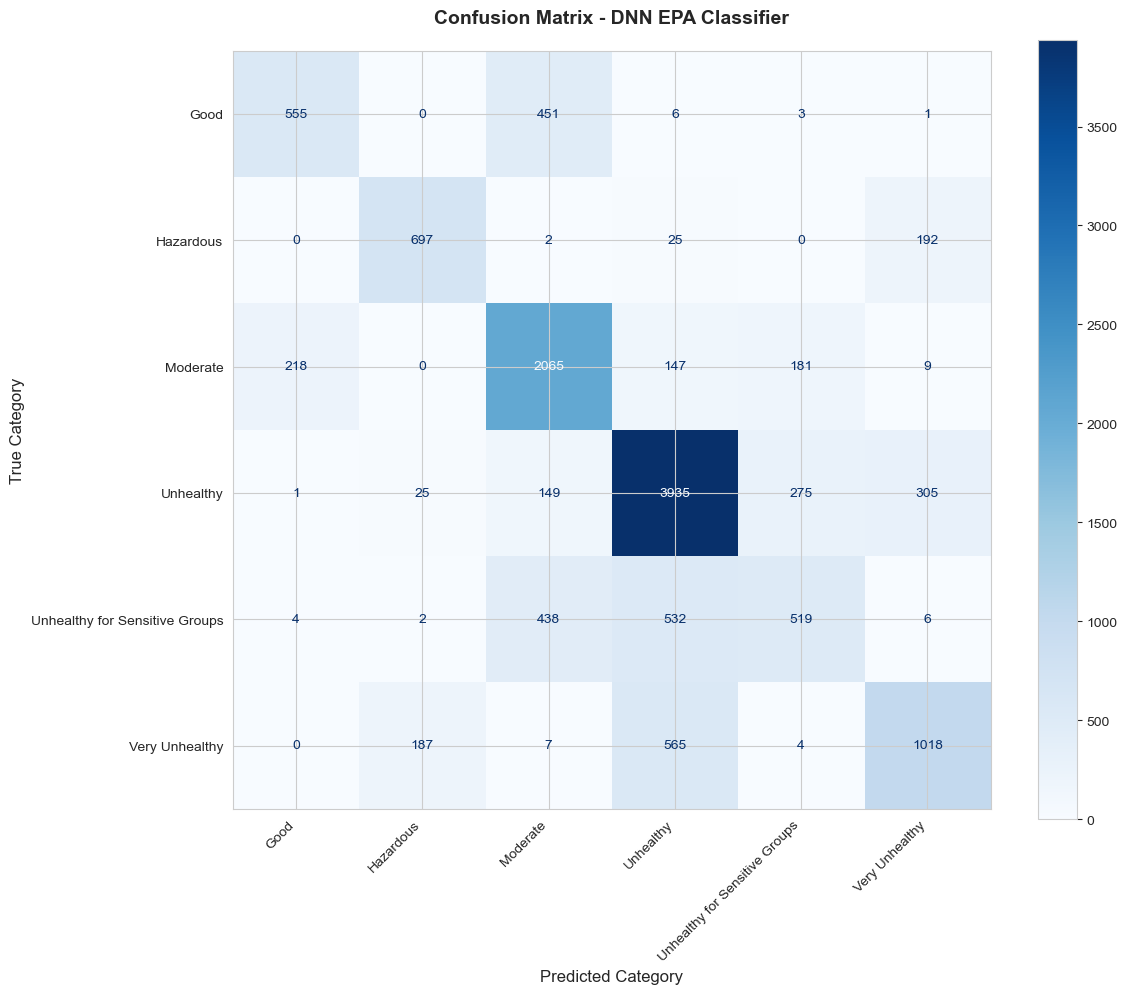

In [18]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 10))

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')

plt.title('Confusion Matrix - DNN EPA Classifier', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Salva figura
fig_path = Path('../figures/classification')
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / 'confusion_matrix_dnn.pdf', dpi=150, bbox_inches='tight')
print(f"\n✓ Confusion matrix salvata: {fig_path / 'confusion_matrix_dnn.pdf'}")

plt.show()

✓ Training history plot salvato: ../figures/classification/dnn_training_history.pdf


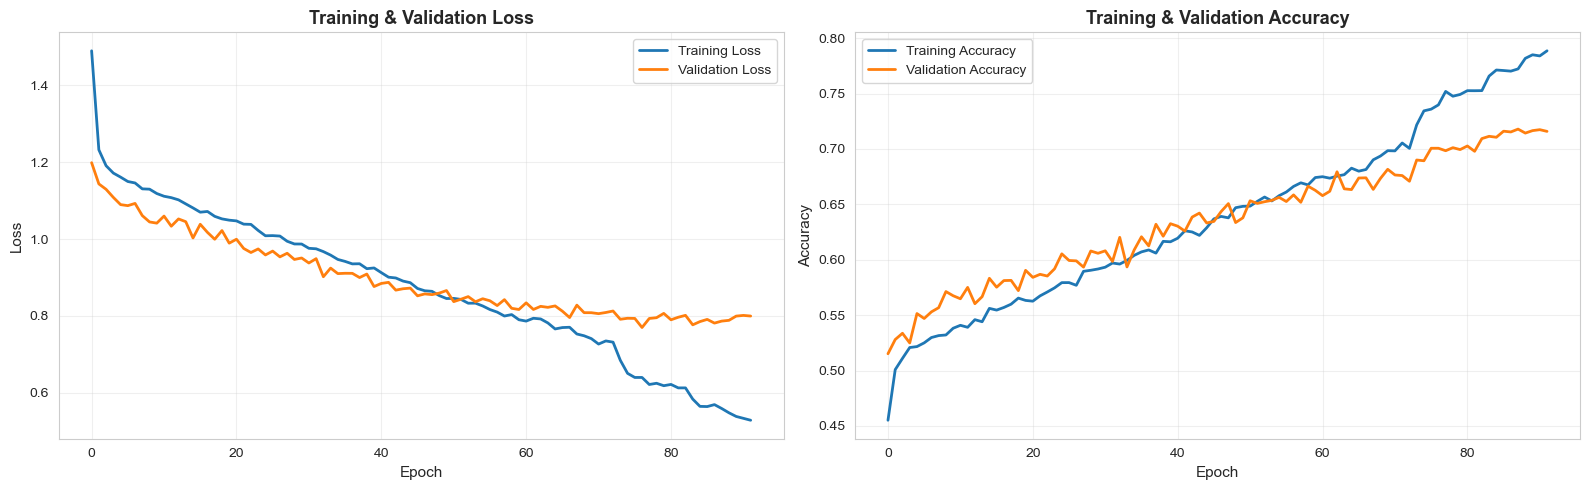


Statistiche Training:
  Best Training Accuracy: 0.7885
  Best Validation Accuracy: 0.7179
  Final Training Loss: 0.5280
  Final Validation Loss: 0.7994
  Total Epochs: 92


In [19]:
# Visualizza training history (se disponibile)
history_path = models_dir / 'dnn_training_history.pkl'

if history_path.exists():
    import pickle
    with open(history_path, 'rb') as f:
        history_dict = pickle.load(f)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loss
    axes[0].plot(history_dict['train_loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history_dict['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_dict['train_acc'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history_dict['val_acc'], label='Validation Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Accuracy', fontsize=11)
    axes[1].set_title('Training & Validation Accuracy', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(fig_path / 'dnn_training_history.pdf', dpi=150, bbox_inches='tight')
    print(f"✓ Training history plot salvato: {fig_path / 'dnn_training_history.pdf'}")
    plt.show()
    
    # Statistiche finali
    print("\nStatistiche Training:")
    print(f"  Best Training Accuracy: {max(history_dict['train_acc']):.4f}")
    print(f"  Best Validation Accuracy: {max(history_dict['val_acc']):.4f}")
    print(f"  Final Training Loss: {history_dict['train_loss'][-1]:.4f}")
    print(f"  Final Validation Loss: {history_dict['val_loss'][-1]:.4f}")
    print(f"  Total Epochs: {len(history_dict['train_loss'])}")
else:
    print("⚠ Training history non disponibile (modello caricato da file esistente)")


ROC CURVES - ANALISI PER CLASSE

AUC Scores per Classe:
  Good                          : 0.9623
  Hazardous                     : 0.9807
  Moderate                      : 0.9322
  Unhealthy                     : 0.9160
  Unhealthy for Sensitive Groups: 0.8744
  Very Unhealthy                : 0.9306

  Micro-average                 : 0.9434
  Macro-average                 : 0.9327

AUC Scores per Classe:
  Good                          : 0.9623
  Hazardous                     : 0.9807
  Moderate                      : 0.9322
  Unhealthy                     : 0.9160
  Unhealthy for Sensitive Groups: 0.8744
  Very Unhealthy                : 0.9306

  Micro-average                 : 0.9434
  Macro-average                 : 0.9327

✓ ROC curves salvate: ../figures/classification/roc_curves_per_class.pdf

✓ ROC curves salvate: ../figures/classification/roc_curves_per_class.pdf


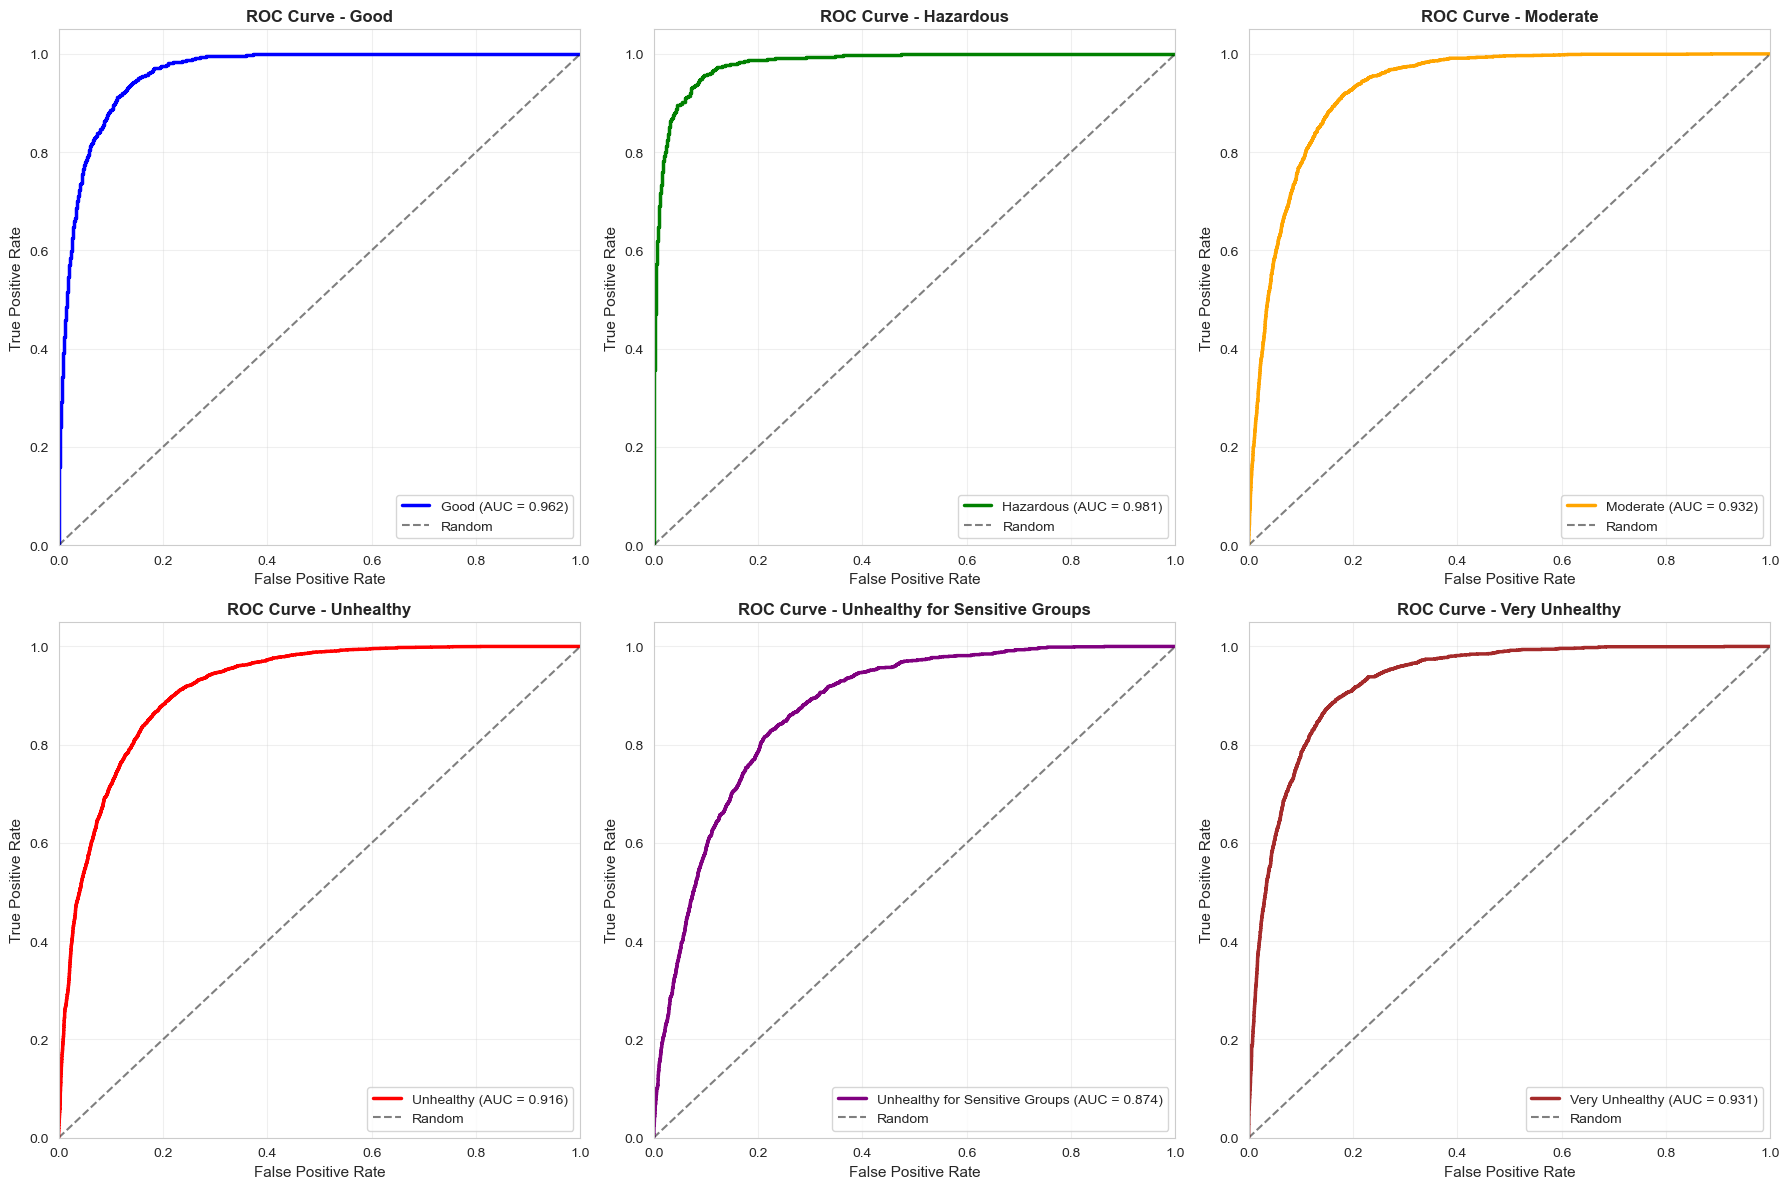

✓ ROC curves aggregate salvate: ../figures/classification/roc_curves_aggregate.pdf


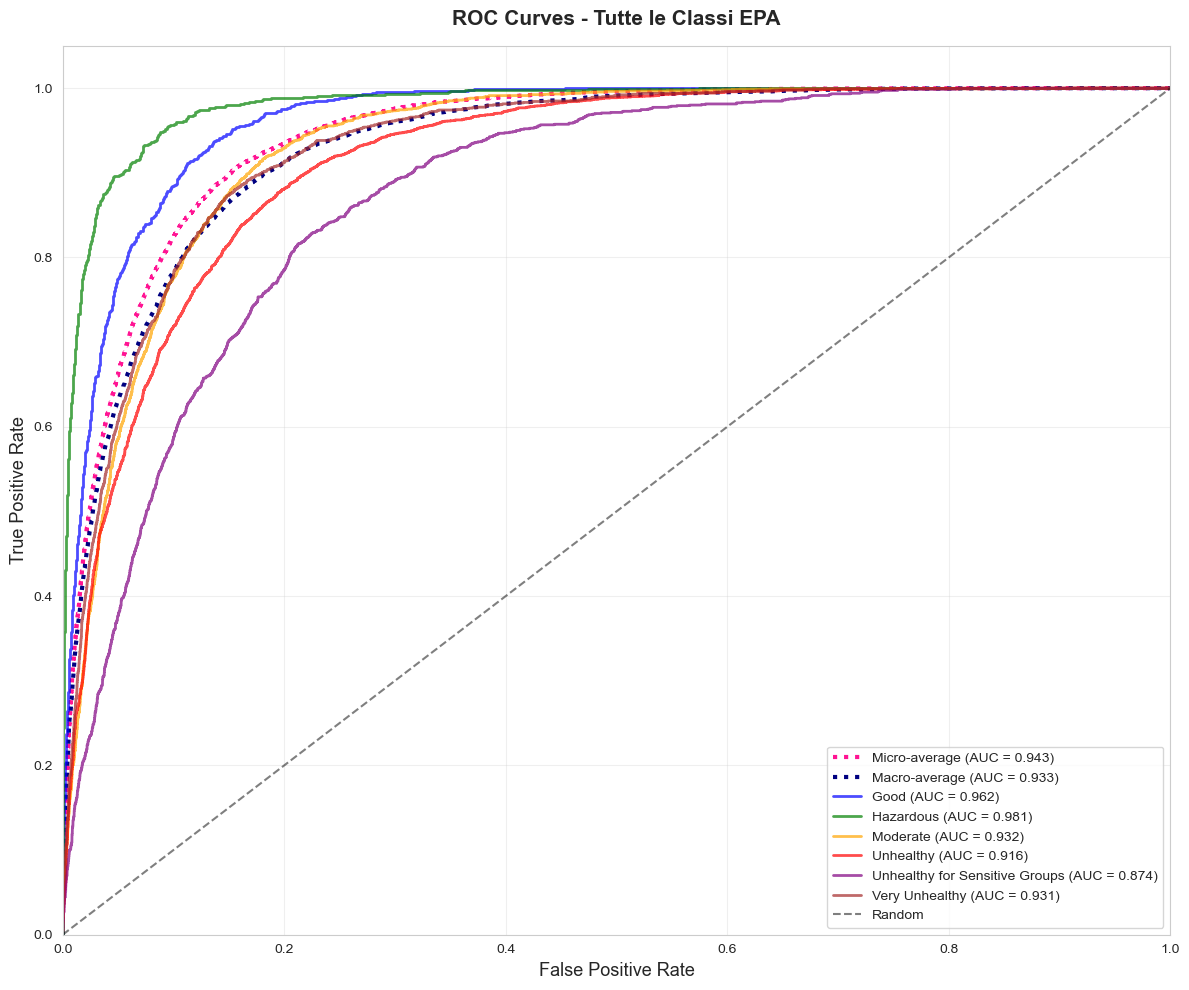

In [20]:
# ROC Curves per tutte le classi
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

print("\n" + "="*60)
print("ROC CURVES - ANALISI PER CLASSE")
print("="*60)

# Ottieni probabilità predette per ogni classe
best_model.eval()
all_probs = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = best_model(X_batch)
        # Applica softmax per ottenere probabilità
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

y_pred_probs = np.array(all_probs)

# Binarizza le etichette per ROC multi-classe
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
n_classes = len(label_encoder.classes_)

# Calcola ROC curve e AUC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcola micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calcola macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Stampa AUC scores
print(f"\nAUC Scores per Classe:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name:30s}: {roc_auc[i]:.4f}")
print(f"\n  {'Micro-average':30s}: {roc_auc['micro']:.4f}")
print(f"  {'Macro-average':30s}: {roc_auc['macro']:.4f}")

# Plot ROC curves
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Colori per le classi
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

# Plot per ogni classe
for i, (class_name, color) in enumerate(zip(label_encoder.classes_, colors)):
    ax = axes[i]
    
    # ROC curve della classe
    ax.plot(fpr[i], tpr[i], color=color, linewidth=2.5,
            label=f'{class_name} (AUC = {roc_auc[i]:.3f})')
    
    # Linea diagonale (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'ROC Curve - {class_name}', fontsize=12, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_path / 'roc_curves_per_class.pdf', dpi=150, bbox_inches='tight')
print(f"\n✓ ROC curves salvate: {fig_path / 'roc_curves_per_class.pdf'}")
plt.show()

# Plot ROC curves aggregate (tutte le classi + micro/macro average)
fig, ax = plt.subplots(figsize=(12, 10))

# Plot micro-average
ax.plot(fpr["micro"], tpr["micro"],
        label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
        color='deeppink', linestyle=':', linewidth=3)

# Plot macro-average
ax.plot(fpr["macro"], tpr["macro"],
        label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
        color='navy', linestyle=':', linewidth=3)

# Plot per ogni classe
for i, (class_name, color) in enumerate(zip(label_encoder.classes_, colors)):
    ax.plot(fpr[i], tpr[i], color=color, linewidth=2, alpha=0.7,
            label=f'{class_name} (AUC = {roc_auc[i]:.3f})')

# Linea diagonale
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curves - Tutte le Classi EPA', fontsize=15, fontweight='bold', pad=15)
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_path / 'roc_curves_aggregate.pdf', dpi=150, bbox_inches='tight')
print(f"✓ ROC curves aggregate salvate: {fig_path / 'roc_curves_aggregate.pdf'}")
plt.show()

print("\n" + "="*60)